## Modelo de clasificacion Pulsar

creador: Luiggi Silva

In [104]:
## Importando librerias
import optuna
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import pickle

In [2]:
## Cargando base de datos (1)
df = pd.read_csv(r"Dataset/Pulsar.csv")

In [3]:
def separate_target(df,target="Target"):
    y = df.loc[:,target]
    X = df.loc[:,df.columns != target]
    return y , X


In [43]:
# La base no contiene Nulos
df.isna().sum()

Mean_Integrated         0
SD                      0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64

In [45]:
df.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


array([[<Axes: title={'center': 'Mean_Integrated'}>,
        <Axes: title={'center': 'SD'}>, <Axes: title={'center': 'EK'}>],
       [<Axes: title={'center': 'Skewness'}>,
        <Axes: title={'center': 'Mean_DMSNR_Curve'}>,
        <Axes: title={'center': 'SD_DMSNR_Curve'}>],
       [<Axes: title={'center': 'EK_DMSNR_Curve'}>,
        <Axes: title={'center': 'Skewness_DMSNR_Curve'}>,
        <Axes: title={'center': 'Class'}>]], dtype=object)

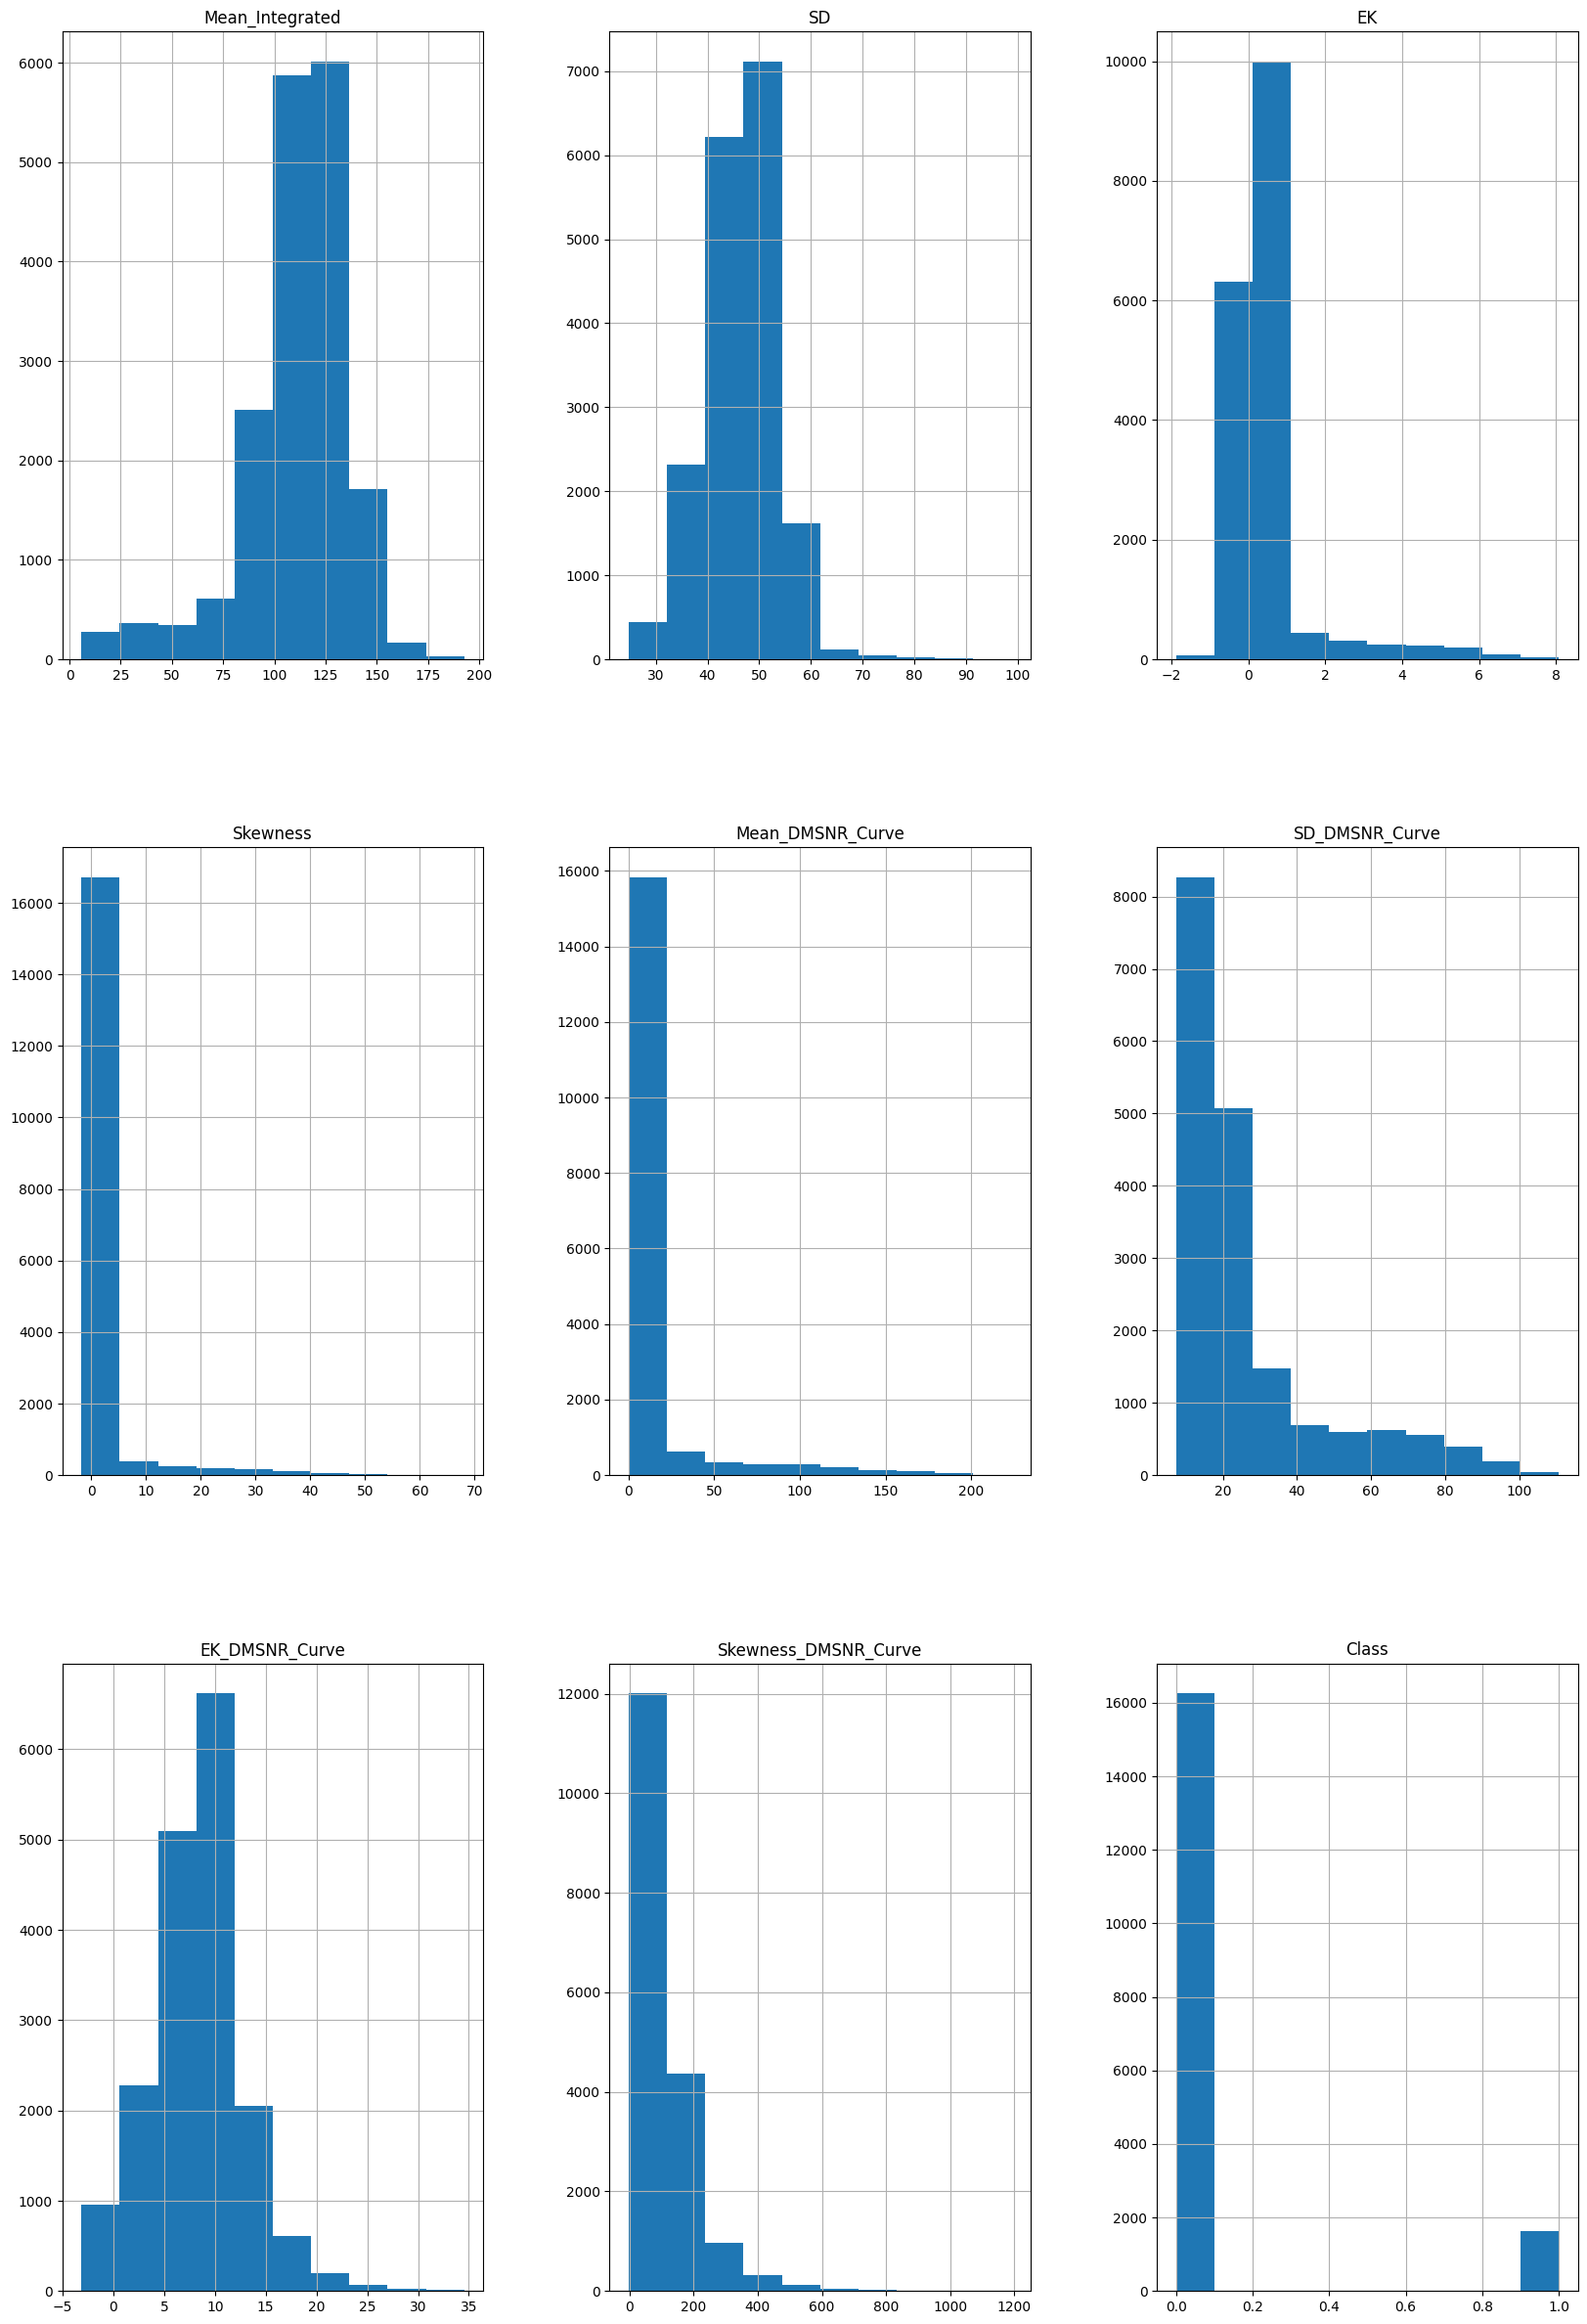

In [47]:
## Eda
df.hist(figsize=(20,30))



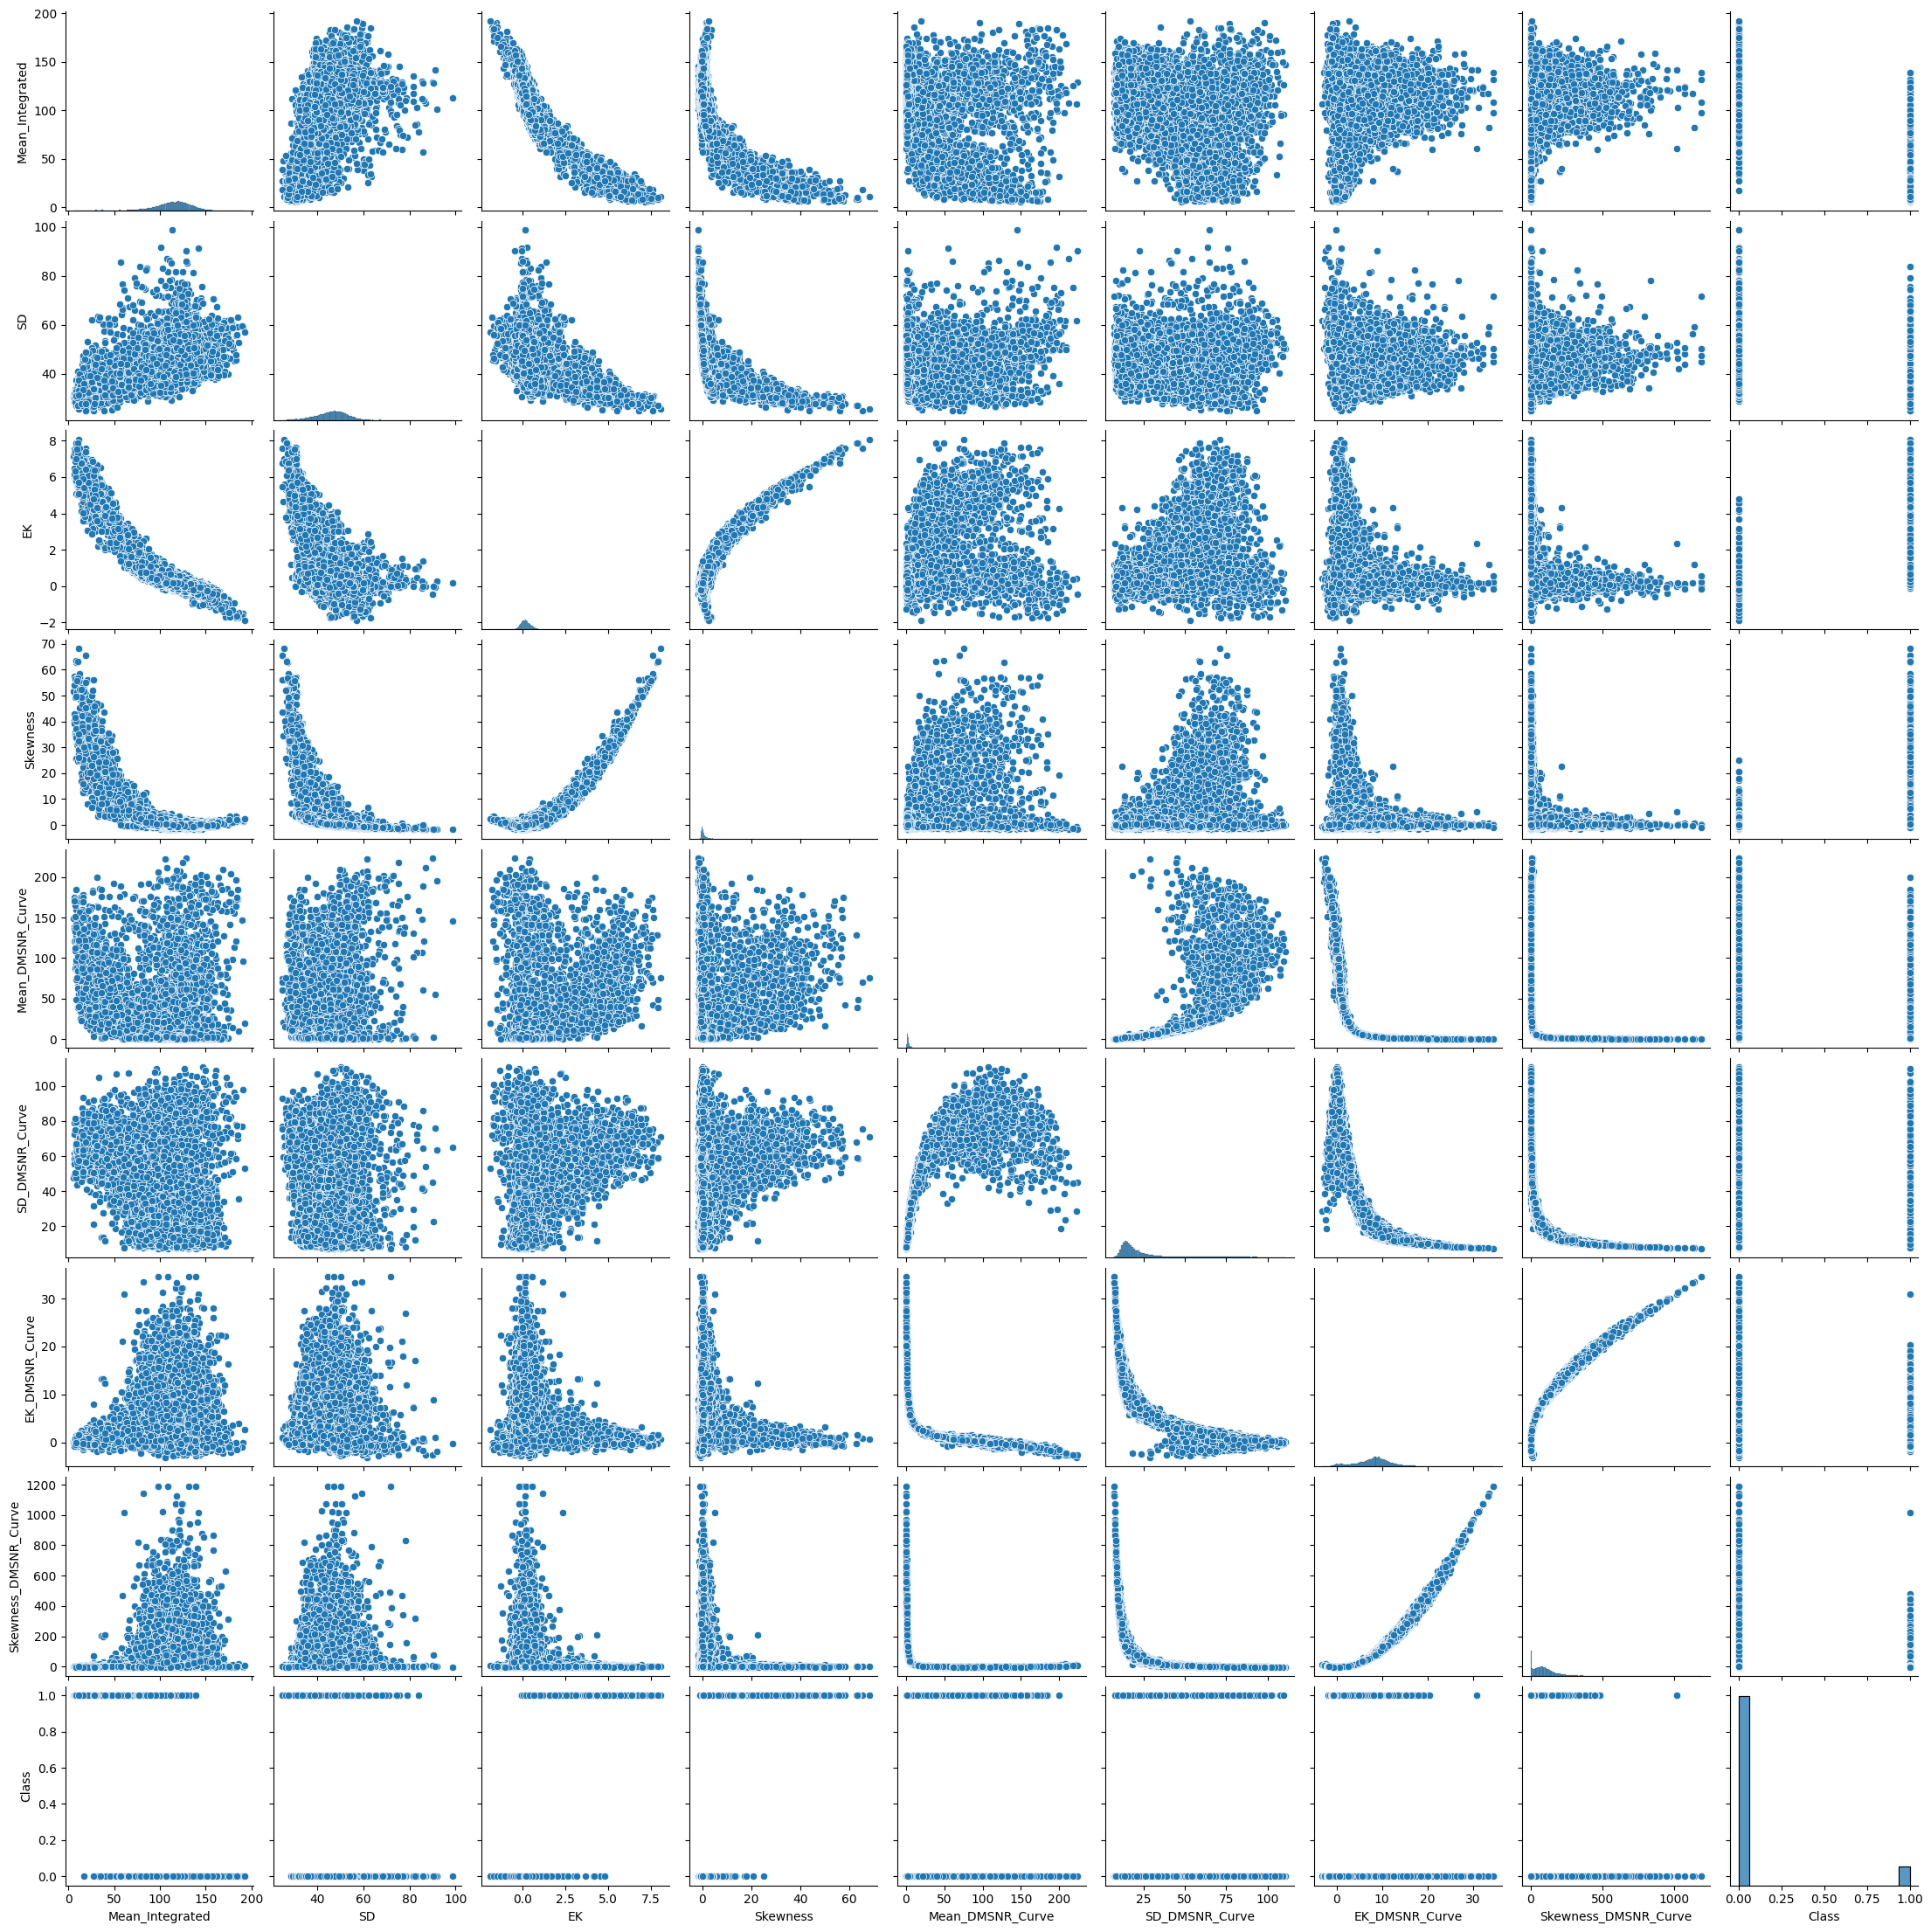

In [51]:
sns.pairplot(df)

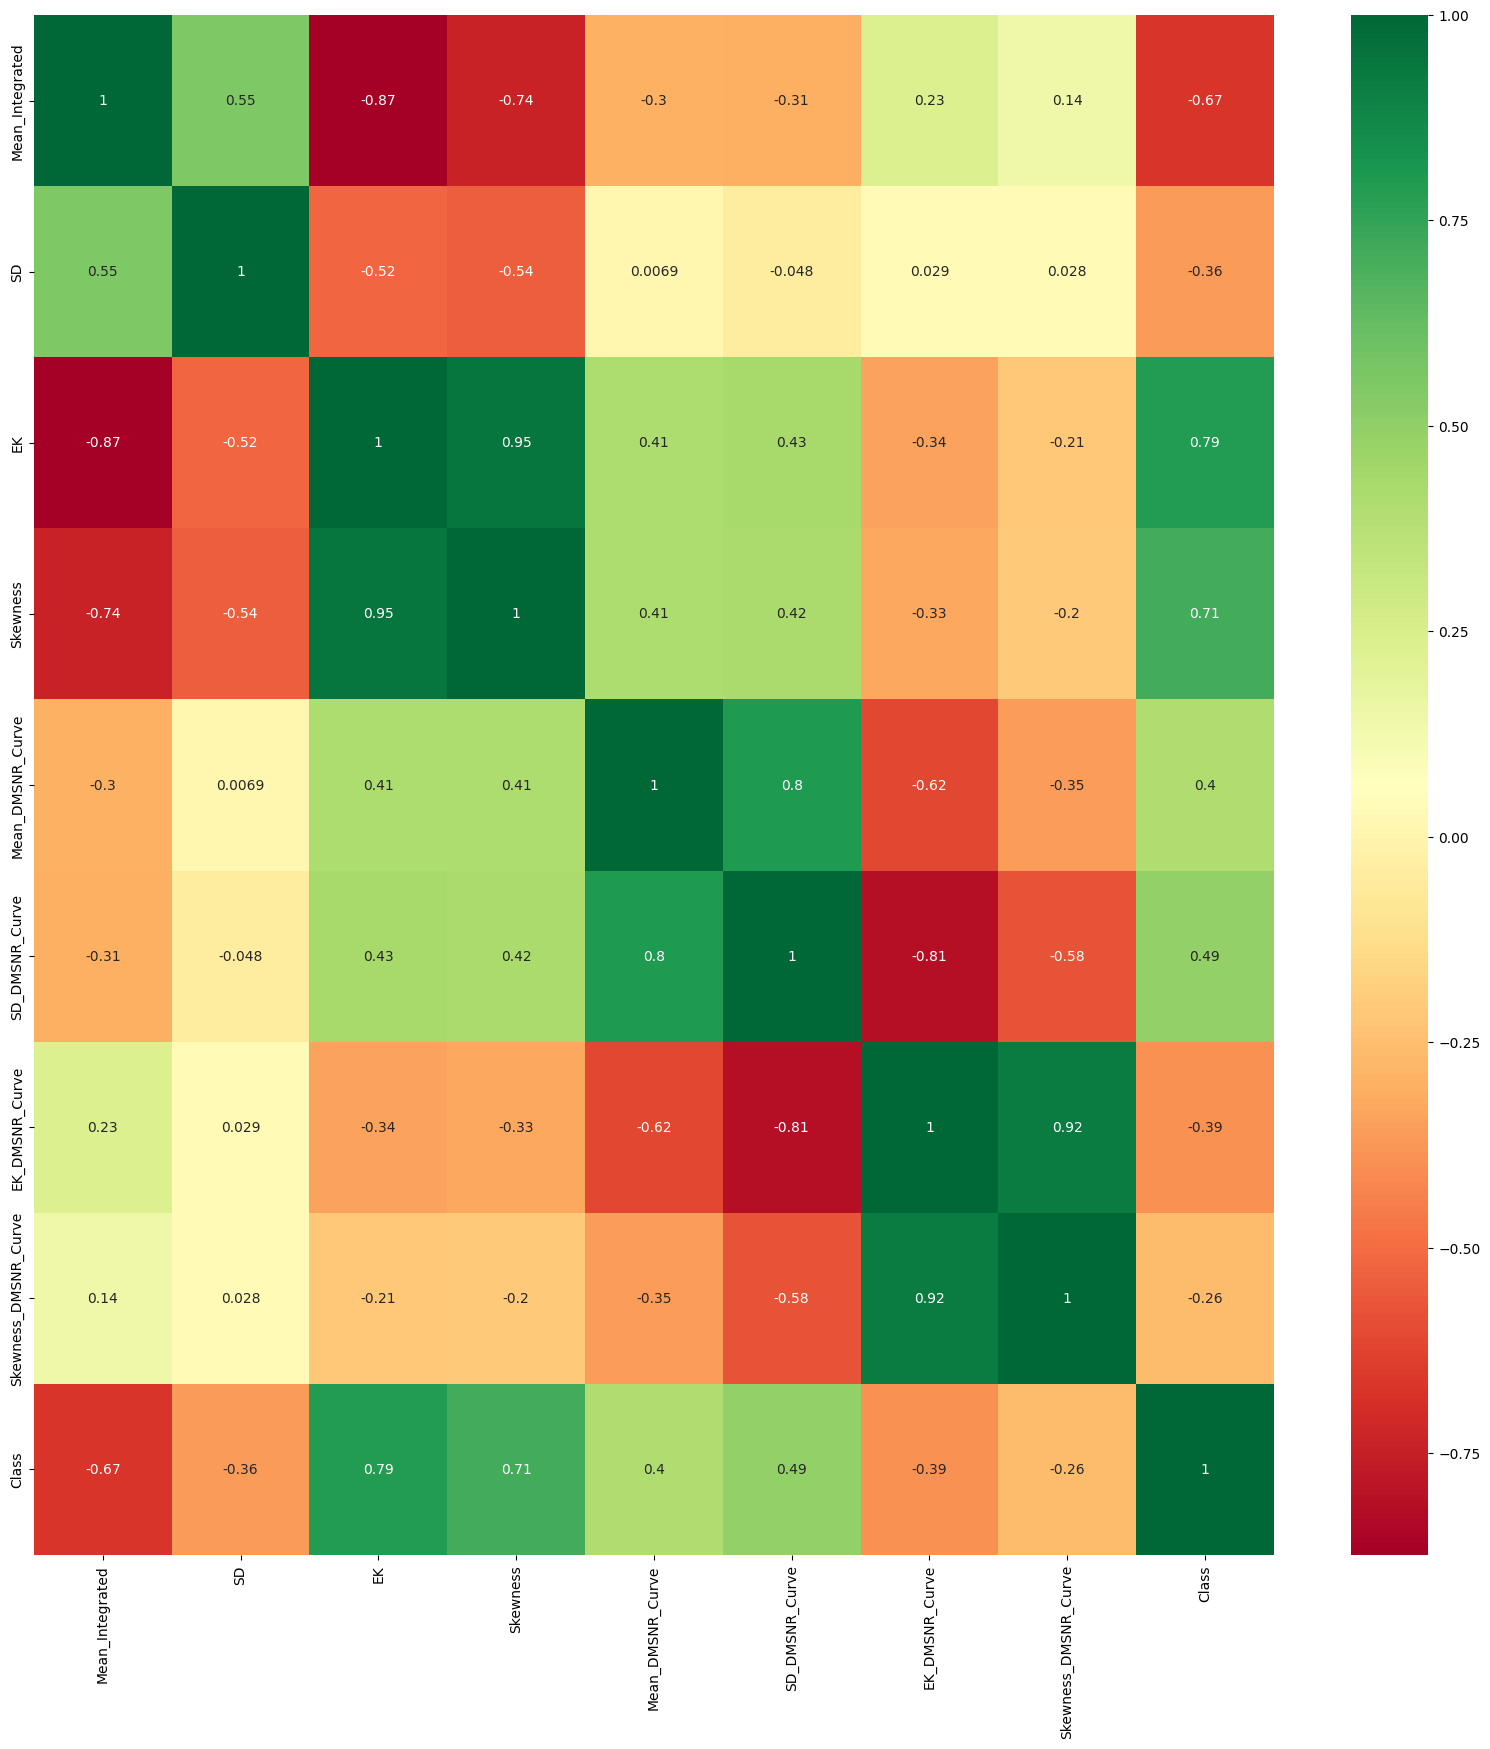

In [52]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
# Split the data into training and testing sets (5)
df_train, df_test = train_test_split(df, test_size=0.2)

[0.17353362 0.05057682 0.29616328 0.22489358 0.07280474 0.07979289
 0.05655722 0.04567785]


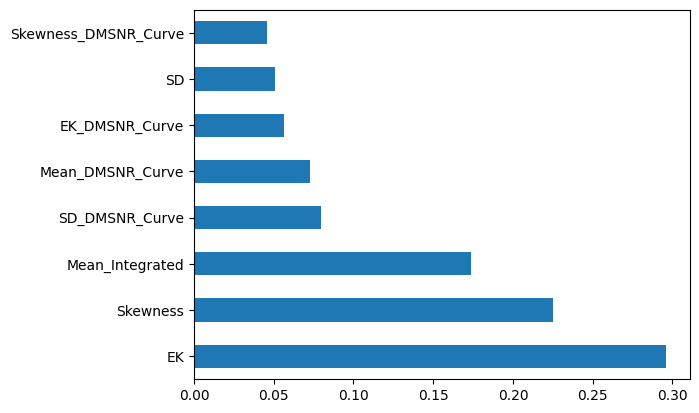

In [74]:
## Feature selection de las variables
y , X= separate_target(df_train,target="Class")
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [76]:
#Crearemos una variables
def FE(df):
    df['Z'] = (df["SD"]*df["SD"] - df["Mean_Integrated"])/df["SD"]
    df['imp'] = (df["EK"]*10)*(df["EK"])+ df['SD_DMSNR_Curve']
    return df


[0.12974124 0.04484805 0.27167147 0.15554592 0.04746876 0.07891801
 0.04387669 0.03044014 0.03712476 0.16036496]


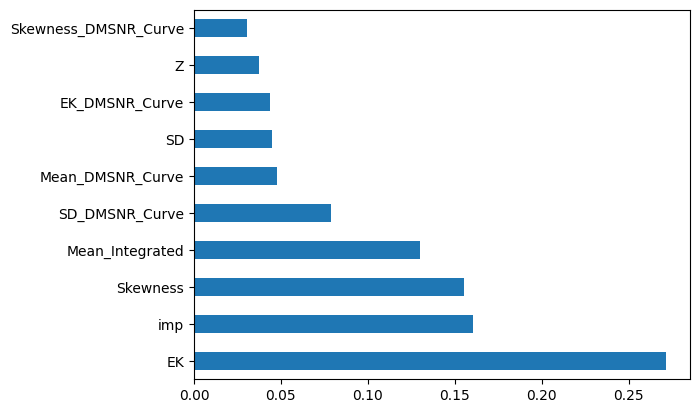

In [77]:
y , X= separate_target(df_train,target="Class")
X = FE(X)
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [78]:
#Nos quedamos con aquellas mayor a 5 %
selected_var = ['EK', 'Mean_Integrated', 'Skewness', 'imp', 'SD_DMSNR_Curve', 'Mean_DMSNR_Curve']

In [88]:
##Normalizaremos las variables
# Selección de las variables por tipo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), selected_var)],
                remainder='passthrough')

In [89]:
# Parametros 
XGB_CV_SPLIT = 5
OPTUNA_XGB = False
OPTUNA_FRACTION = True
LGB_STACKING = False
# For Filtering Folds
XGB_CV_SPLIT_upd = XGB_CV_SPLIT
XGB_FOLD_FILTER = False
# Thresholds
XGB_FOLD_TH, LGB_FOLD_TH = 0.04, 0.04


In [90]:
y , X = separate_target(df_train,target="Class")
def xgb_cv(n_split, X, y, params, optuna=False):
    X = X.loc[:,selected_var]
    global XGB_CV_SPLIT_upd
    skf = StratifiedKFold(n_splits=n_split, 
#                                   n_repeats=3,
                                  shuffle=True, 
                                  random_state=9)
    log_losses = []
    all_clf = []
    oof_pred = pd.Series(0, index=X.index)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train = preprocessor.fit_transform(X_train)
        X_test  = preprocessor.transform(X_test)
        # Classifier
        clf = XGBClassifier(**params, tree_method="gpu_hist", 
                            n_jobs= -1, enable_categorical= True,
                            eval_metric='logloss')
        clf.fit(X_train, y_train, 
                eval_set=[(X_test, y_test)], 
                verbose=0)
        
        # Prediction
        y_pred = clf.predict_proba(X_test)[:, 1].astype(np.float64)
        oof_pred.iloc[test_idx] = y_pred
        
        # Score
        curr_log_loss = log_loss(y_test, y_pred)

        if XGB_FOLD_FILTER == True:
            if curr_log_loss < XGB_FOLD_TH:
                all_clf.append(clf)
                log_losses.append(curr_log_loss)
            else:
                XGB_CV_SPLIT_upd-=1
                print('-', end='')
        else:
            all_clf.append(clf)
            log_losses.append(curr_log_loss)
        print(f'Fold {i+1}, log loss: {curr_log_loss}')
    if optuna == True:
        return np.mean(log_losses)
    return all_clf, np.mean(log_losses), oof_pred

In [91]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 18),
        'eta': trial.suggest_float('eta', 1e-8, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'n_estimators': 100
    }
    
    return xgb_cv(XGB_CV_SPLIT, FE(X), y, params, optuna=True)

In [92]:
xgb_study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
xgb_study.optimize(objective_xgb, n_trials=100, show_progress_bar=True)

[I 2023-06-29 23:38:57,099] A new study created in memory with name: no-name-33563785-457a-41e3-9f9b-70f90a542f51


  0%|          | 0/100 [00:00<?, ?it/s]

Fold 1, log loss: 0.09013536581823278
Fold 2, log loss: 0.10715439900873287
Fold 3, log loss: 0.0913757444915467
Fold 4, log loss: 0.0930806793407487
Fold 5, log loss: 0.11797147387923819
[I 2023-06-29 23:39:00,519] Trial 0 finished with value: 0.09994353250769984 and parameters: {'max_depth': 8, 'eta': 0.7753421821312723, 'min_child_weight': 3, 'gamma': 0.3110240230584795, 'subsample': 0.8182826065611029, 'colsample_bytree': 0.8439913792758349, 'reg_alpha': 0.6511231052309163, 'reg_lambda': 0.14105554045248064}. Best is trial 0 with value: 0.09994353250769984.
Fold 1, log loss: 0.07647645690591748
Fold 2, log loss: 0.07728247794924058
Fold 3, log loss: 0.0767900700221397
Fold 4, log loss: 0.0712376724389888
Fold 5, log loss: 0.09126600781075987
[I 2023-06-29 23:39:03,253] Trial 1 finished with value: 0.0786105370254093 and parameters: {'max_depth': 15, 'eta': 0.14319562414734954, 'min_child_weight': 8, 'gamma': 0.04757901399188811, 'subsample': 0.41517845850914104, 'colsample_bytree':

Fold 1, log loss: 0.07143688623768031
Fold 2, log loss: 0.06927808828403138
Fold 3, log loss: 0.06818290236139632
Fold 4, log loss: 0.06852912047561278
Fold 5, log loss: 0.08578790425966594
[I 2023-06-29 23:39:40,309] Trial 15 finished with value: 0.07264298032367734 and parameters: {'max_depth': 18, 'eta': 0.27743004593415915, 'min_child_weight': 8, 'gamma': 0.7946905185969739, 'subsample': 0.7033727665777401, 'colsample_bytree': 0.5814347190580912, 'reg_alpha': 0.9508905410705735, 'reg_lambda': 0.38906994385175886}. Best is trial 11 with value: 0.07049278059387129.
Fold 1, log loss: 0.0705737136925116
Fold 2, log loss: 0.07065009525110924
Fold 3, log loss: 0.06807417616489644
Fold 4, log loss: 0.07071877156848222
Fold 5, log loss: 0.0846969297038328
[I 2023-06-29 23:39:42,394] Trial 16 finished with value: 0.07294273727616647 and parameters: {'max_depth': 11, 'eta': 0.4300081412729351, 'min_child_weight': 6, 'gamma': 0.5455737550308837, 'subsample': 0.9967288044349195, 'colsample_byt

Fold 1, log loss: 0.06953971056232575
Fold 2, log loss: 0.069071015402934
Fold 3, log loss: 0.06852759116394355
Fold 4, log loss: 0.06873940443903247
Fold 5, log loss: 0.0818082816647312
[I 2023-06-29 23:40:18,658] Trial 30 finished with value: 0.07153720064659339 and parameters: {'max_depth': 8, 'eta': 0.11066075230378217, 'min_child_weight': 6, 'gamma': 0.3693803543844793, 'subsample': 0.7923214749457708, 'colsample_bytree': 0.8727600337991788, 'reg_alpha': 0.6313398561768466, 'reg_lambda': 0.1446296841225757}. Best is trial 25 with value: 0.07015511219618414.
Fold 1, log loss: 0.06926133293687517
Fold 2, log loss: 0.06860603365229319
Fold 3, log loss: 0.06687907268218259
Fold 4, log loss: 0.06733314760795739
Fold 5, log loss: 0.08228452075519407
[I 2023-06-29 23:40:21,656] Trial 31 finished with value: 0.07087282152690048 and parameters: {'max_depth': 8, 'eta': 0.09427839379319776, 'min_child_weight': 8, 'gamma': 0.33865424367353947, 'subsample': 0.8550918278924986, 'colsample_bytre

Fold 1, log loss: 0.0703210340685142
Fold 2, log loss: 0.06757960717882634
Fold 3, log loss: 0.06622461393141066
Fold 4, log loss: 0.06558737110782184
Fold 5, log loss: 0.08358190306513177
[I 2023-06-29 23:41:01,109] Trial 45 finished with value: 0.07065890587034096 and parameters: {'max_depth': 11, 'eta': 0.12813456064993928, 'min_child_weight': 10, 'gamma': 0.2134820325662612, 'subsample': 0.6435174731328982, 'colsample_bytree': 0.928971174889125, 'reg_alpha': 0.3616298451411663, 'reg_lambda': 0.11859050028922949}. Best is trial 36 with value: 0.0698009917985527.
Fold 1, log loss: 0.07000895953900277
Fold 2, log loss: 0.06822426492739037
Fold 3, log loss: 0.06638042145102141
Fold 4, log loss: 0.06666357117617451
Fold 5, log loss: 0.08030843561554932
[I 2023-06-29 23:41:03,830] Trial 46 finished with value: 0.07031713054182767 and parameters: {'max_depth': 8, 'eta': 0.053187059454859395, 'min_child_weight': 10, 'gamma': 0.38961624712153603, 'subsample': 0.7806780867921074, 'colsample_

Fold 1, log loss: 0.07091746864180123
Fold 2, log loss: 0.06952794295437795
Fold 3, log loss: 0.06798273943704218
Fold 4, log loss: 0.06829666109659065
Fold 5, log loss: 0.0855214387927146
[I 2023-06-29 23:41:42,859] Trial 60 finished with value: 0.07244925018450532 and parameters: {'max_depth': 12, 'eta': 0.1982351364901411, 'min_child_weight': 10, 'gamma': 0.46837984071747735, 'subsample': 0.9420275709459205, 'colsample_bytree': 0.9488736749806262, 'reg_alpha': 0.528184514377749, 'reg_lambda': 0.36959130846562466}. Best is trial 51 with value: 0.06960056418598114.
Fold 1, log loss: 0.06900130484534617
Fold 2, log loss: 0.06864260863181083
Fold 3, log loss: 0.06560018025095653
Fold 4, log loss: 0.06737607280634274
Fold 5, log loss: 0.08031370063491144
[I 2023-06-29 23:41:45,987] Trial 61 finished with value: 0.07018677343387354 and parameters: {'max_depth': 10, 'eta': 0.06867719016291876, 'min_child_weight': 9, 'gamma': 0.4410569045007573, 'subsample': 0.9602191031389801, 'colsample_b

Fold 1, log loss: 0.07028957682183176
Fold 2, log loss: 0.07461582939472289
Fold 3, log loss: 0.06764391569622384
Fold 4, log loss: 0.07156873979792967
Fold 5, log loss: 0.0850894986287922
[I 2023-06-29 23:42:26,418] Trial 75 finished with value: 0.07384151206790006 and parameters: {'max_depth': 7, 'eta': 0.17198602637925514, 'min_child_weight': 4, 'gamma': 0.3481801199821558, 'subsample': 0.9083567587416819, 'colsample_bytree': 0.8934566652656726, 'reg_alpha': 0.665912056931255, 'reg_lambda': 0.3769843067200864}. Best is trial 51 with value: 0.06960056418598114.
Fold 1, log loss: 0.08318707007405374
Fold 2, log loss: 0.08074454440856815
Fold 3, log loss: 0.07965373473817072
Fold 4, log loss: 0.07956761423661231
Fold 5, log loss: 0.08911924880776595
[I 2023-06-29 23:42:30,066] Trial 76 finished with value: 0.08245444245303417 and parameters: {'max_depth': 8, 'eta': 0.031542281322615176, 'min_child_weight': 8, 'gamma': 0.4782640545989802, 'subsample': 0.7378951915197913, 'colsample_bytr

Fold 1, log loss: 0.139713101117218
Fold 2, log loss: 0.13787233651390032
Fold 3, log loss: 0.1366841615821579
Fold 4, log loss: 0.13711656602658787
Fold 5, log loss: 0.1440595686044691
[I 2023-06-29 23:43:11,056] Trial 90 finished with value: 0.13908914676886663 and parameters: {'max_depth': 10, 'eta': 0.01762673985640588, 'min_child_weight': 9, 'gamma': 0.5555977569678048, 'subsample': 0.7659703716028619, 'colsample_bytree': 0.9236813486361822, 'reg_alpha': 0.7985319462062338, 'reg_lambda': 0.4508743792687093}. Best is trial 51 with value: 0.06960056418598114.
Fold 1, log loss: 0.0702206264551743
Fold 2, log loss: 0.06829228679906495
Fold 3, log loss: 0.06680767274126637
Fold 4, log loss: 0.06709423484965349
Fold 5, log loss: 0.08021301678583549
[I 2023-06-29 23:43:13,834] Trial 91 finished with value: 0.07052556752619892 and parameters: {'max_depth': 9, 'eta': 0.05087575354441624, 'min_child_weight': 10, 'gamma': 0.42052531992884307, 'subsample': 0.7317884722580276, 'colsample_bytre

In [93]:
print('Number of finished trials: {}'.format(len(xgb_study.trials)))
print('Best trial:')
trial = xgb_study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.06960056418598114
  Params: 
    max_depth: 8
    eta: 0.06380138941254017
    min_child_weight: 10
    gamma: 0.3762035149595784
    subsample: 0.7992752325201137
    colsample_bytree: 0.9577716505461795
    reg_alpha: 0.6619201545786603
    reg_lambda: 0.28990983546602866


In [97]:
params = trial.params
model_xgb = XGBClassifier(**params)
y_train , X_train = separate_target(df_train,target="Class")
X_train = preprocessor.fit_transform(FE(X_train).loc[:,selected_var])
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9577716505461795, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06380138941254017,
              eval_metric=None, feature_types=None, gamma=0.3762035149595784,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [98]:
y_test , X_test = separate_target(df_test,target="Class")
X_test  = preprocessor.transform(FE(X_test).loc[:,selected_var])

y_pred = model_xgb.predict(X_test)

In [99]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (accuracy * 100.0))

Accuracy after tuning: 97.93%


In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3251
           1       0.94      0.83      0.88       329

    accuracy                           0.98      3580
   macro avg       0.96      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580



In [105]:
file_name = "xgb_reg.pkl"

# save
pickle.dump(model_xgb, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))




In [106]:
with open('PII_model.pickle', 'wb') as picklefile:
    pickle.dump(preprocessor, picklefile)

In [107]:
preprocessor_loaded = pickle.load(open('PII_model.pickle', "rb"))

In [111]:
preprocessor_loaded.transform(FE(X_test).loc[:,selected_var])

array([[-0.07461829, -0.21199635, -0.20711331, -0.42533507, -0.83065623,
        -0.40466688],
       [ 0.2359694 , -1.2936216 ,  0.11265396, -0.32151169, -0.66833354,
        -0.35994308],
       [-0.18516417,  0.68309968, -0.22035166, -0.37099137, -0.60507836,
        -0.35065971],
       ...,
       [-0.1578515 , -0.49530096, -0.06886092, -0.25932671, -0.23428943,
        -0.31538857],
       [ 0.10409094, -0.88453951,  0.12682054, -0.34191074, -0.64308862,
        -0.34738655],
       [-0.31450829,  0.77285351, -0.28253323, -0.36338179, -0.54939178,
        -0.33810318]])